# 1
# PPFQ

## Data Mining

-48-

Buscamos patrones o indicadores que nos brinden señales.

Ejemplo: dos indicadores

objetivo: investigar entre muchos indicadores, correlaciones contra el precio, o el retorno futuro del mismo.

"Testear bot de trading del tipo trend-following, con cruce de medias y oscilador tipo RSI."

In [11]:
from dotenv import load_dotenv
import os
from apps.forex_module import fx_price
import pandas as pd
import numpy as np
import seaborn as sns


load_dotenv()
TOKEN = os.environ["TOKEN_AV"]
# data = fx_price("FX_DAILY", "EUR", "USD", TOKEN)

In [12]:
# data.to_csv('data-daily-raw.csv')

data = pd.read_csv("data-daily-raw.csv", index_col=0)

In [13]:
# PARAMETROS INCIALES
ruedas = 14
par = "EUR/JPY"
fast, slow = 20, 60
sigma = 40

fw = 10, 20

features = [f"Cruce_{fast}_{slow}", "rsi", f"sigma_{sigma}"]  # atributo dinámico
forwards = [f"fw_{i}" for i in fw]  # atributo preseteado, dinámico

In [14]:
# AJUSTE DE DATA
new_labels = ["Open", "High", "Low", "Close"]

data.rename(dict(zip(data.columns, new_labels)), axis=1, inplace=True)

data = data.iloc[-1::-1]

In [15]:
# cruce de SMAs
def cruce_sma_fast_slow(data, fast, slow):
    dataux = pd.DataFrame()
    dataux[f"SMA_{fast}"] = data.loc[:, "Close"].rolling(fast).mean()
    dataux[f"SMA_{slow}"] = data.loc[:, "Close"].rolling(slow).mean()
    data.loc[:, f"Cruce_{fast}_{slow}"] = (
        dataux.loc[:, f"SMA_{fast}"] / dataux.loc[:, f"SMA_{slow}"] * 100 - 100
    )
    return data


data = cruce_sma_fast_slow(data, fast, slow)


# calculo rsi
def rsi(data, ruedas):
    dataux = pd.DataFrame()
    dataux["dif"] = data.Close.diff()
    dataux["win"] = np.where(dataux["dif"] > 0, dataux["dif"], 0)
    dataux["loss"] = np.where(dataux["dif"] < 0, abs(dataux["dif"]), 0)
    dataux["ema_win"] = dataux.win.ewm(alpha=1 / ruedas).mean()
    dataux["ema_loss"] = dataux.loss.ewm(alpha=1 / ruedas).mean()
    dataux["rs"] = dataux.ema_win / dataux.ema_loss
    data.loc[:, "rsi"] = 100 - (100 / (1 + dataux.loc[:, "rs"]))
    return data


data = rsi(data, ruedas)


# Calculo volatilidad
def volatilidad(data, sigma):
    data.loc[:, "variacion"] = data.loc[:, "Close"].pct_change() * 100
    data.loc[:, f"sigma_{sigma}"] = data.loc[:, "variacion"].rolling(sigma).std() * (
        sigma**0.5
    )
    return data


data = volatilidad(data, sigma)


def forward(data, fw):
    for step in fw:
        data[f"fw_{step}"] = (data.Close.shift(-step) / data.Close.shift() - 1) * 100
    return data


data = forward(data, fw)


def ajustar_datos(data, features):
    data = data.iloc[:, 3:].dropna()
    data.loc[:, features] = data.loc[:, features].shift()
    return data.round(4)


data = ajustar_datos(data, features)

data

,Close,Cruce_20_60,rsi,variacion,sigma_40,fw_10,fw_20
2003-11-20,1.1907,NaN,NaN,0.1261,NaN,1.6229,4.4147
2003-11-21,1.1914,1.2392,64.2563,0.0588,4.4073,2.1668,4.0312
2003-11-24,1.1764,1.1583,64.5471,-1.2590,4.4016,2.5936,4.1380
2003-11-25,1.1791,1.0542,54.3429,0.2295,4.5063,4.1227,5.3128
2003-11-26,1.1921,0.9633,55.7005,1.1025,4.4561,3.5451,5.5381
...,...,...,...,...,...,...,...
2022-09-26,0.9609,-1.2558,28.8279,-0.8349,3.9735,0.1197,1.8473
2022-09-27,0.9594,-1.3159,25.8263,-0.1571,4.0049,0.9741,3.7142
2022-09-28,0.9733,-1.4158,25.2968,1.4509,3.9250,1.1570,5.0625
2022-09-29,0.9817,-1.5000,37.9295,0.8579,4.2325,0.4510,2.3743


[(-10.0, 10.0)]

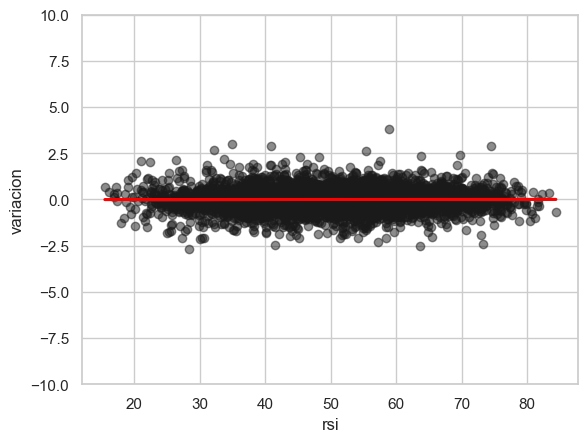

In [16]:
# Look-Ahead Bias
"""Es necesario tomar todos los indicadores y atrasarlos un día, porque "hoy operamos con los indicadores de ayer" """


"""
La tarea a realizar es determinar si existe correlación entre las features y la fluctuación del precio.
También identificar si generan algún tipo de clasificación diferenciable.
"""

sns.set(style="whitegrid")
g = sns.regplot(
    x="rsi",
    y="variacion",
    data=data,
    line_kws={"color": "red"},
    scatter_kws={"color": "k", "alpha": 0.5},
)

g.set(ylim=(-10, 10))

### Correlación features vs variación

-51-

In [17]:
for feature in features:
    r2 = data[feature].corr(data.variacion)
    print(f"El r2 con {feature} es {r2:.2f}")

El r2 con Cruce_20_60 es 0.00
El r2 con rsi es 0.00
El r2 con sigma_40 es -0.00


In [18]:
# TODO: la variable "variacion" está hardcodeada, esto se soluciona creando una clase
data.corr().loc[["variacion"] + forwards, features].round(2)

,Cruce_20_60,rsi,sigma_40
variacion,0.00,0.00,-0.00
fw_10,0.00,0.02,-0.00
fw_20,0.01,0.05,0.02


### Clasificación diferenciable

-55-

La cuestión es separar los variacion expost (fw) si el indicador refleja alguna diferencia o no.

In [19]:
data["variacion_tipo"] = np.where(data.variacion > 0, "Up", "Down")

medias = data.groupby("variacion_tipo").mean().loc[:, features].round(2)
desvios = data.groupby("variacion_tipo").std().loc[:, features].round(2)

print(f"Medias según clasificación \n{medias}\n")
print(f"Desvíos según clasificación \n{desvios}\n")

Medias según clasificación 
                Cruce_20_60    rsi  sigma_40
variacion_tipo                              
Down                  -0.07  50.06      3.40
Up                    -0.04  49.79      3.41

Desvíos según clasificación 
                Cruce_20_60    rsi  sigma_40
variacion_tipo                              
Down                   1.69  12.05      1.26
Up                     1.70  12.10      1.23



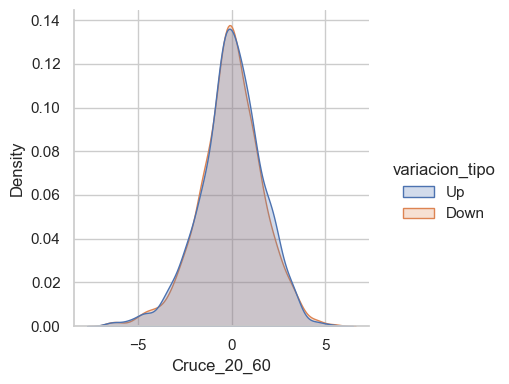

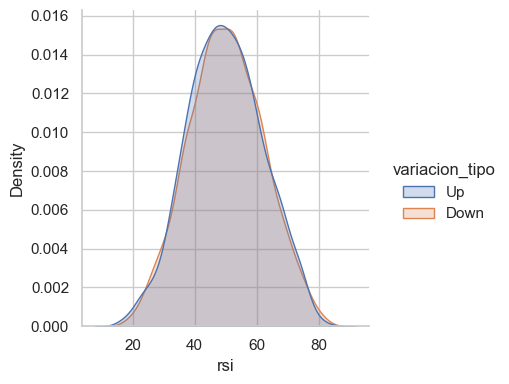

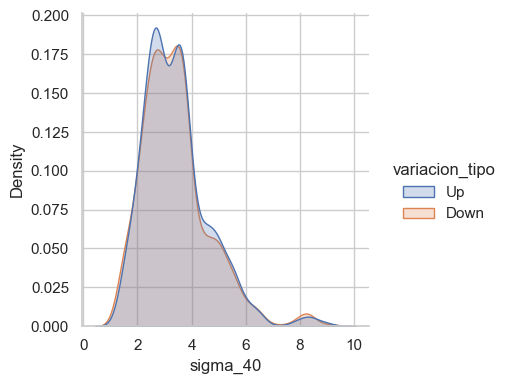

In [20]:
for feature in features:
    sns.displot(data, x=feature, hue="variacion_tipo", kind="kde", height=4, fill=True)

## Construcción de indicadores

-57-